In [ ]:
# Check and enable GPU
!nvidia-smi
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Sat Jun 21 16:45:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Import the necessary libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt


## Data Preparation and Loading

We prepare the MNIST dataset using torchvision, applying a simple transformation to convert images to tensors. The training data is loaded using a DataLoader for efficient batching and shuffling. This setup is essential for training the Conditional Variational Autoencoder (CVAE) model on handwritten digit images.

In [13]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)


## Model Architecture

We define a Conditional Variational Autoencoder (CVAE) model using PyTorch. The encoder takes both the input image and its corresponding label (as an additional channel), processes them through convolutional layers, and outputs the mean and log-variance for the latent space. The decoder reconstructs the image from the latent vector concatenated with the label information. This architecture enables the model to generate images conditioned on specific digit labels, allowing for controlled generation of handwritten digits.

In [14]:
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [ ]:
class CVAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.label_dim = 10 

        # Encoder: takes image + label
        self.encoder = nn.Sequential(
            nn.Conv2d(1 + 1, 32, kernel_size=3, stride=2, padding=1),  # 1 (image) + 1 (label as channel)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        self.flattened_size = 64 * 7 * 7

        self.fc_mu = nn.Linear(self.flattened_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flattened_size, latent_dim)

        # Decoder: takes latent vector + label
        self.decoder_input = nn.Linear(latent_dim + self.label_dim, 64 * 7 * 7)

        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Output range [0, 1]
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, labels_onehot):
        # Expand label to match image size for conditioning
        label_map = labels_onehot.view(-1, 10, 1, 1).repeat(1, 1, 28, 28)  # shape: [batch, 10, 28, 28]
        x_cond = torch.cat([x, label_map[:, 0:1, :, :]], dim=1)  # use only 1 channel from label

        encoded = self.encoder(x_cond)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        z = self.reparameterize(mu, logvar)

        z_cond = torch.cat([z, labels_onehot], dim=1)
        dec_input = self.decoder_input(z_cond)
        x_recon = self.decoder(dec_input)
        return x_recon, mu, logvar


## Model Training

We train the Conditional Variational Autoencoder (CVAE) using the MNIST training dataset. For each epoch, the model processes batches of images and their corresponding labels, computes the reconstruction and KL divergence losses, and updates the model parameters using the Adam optimizer. The training loop prints the average loss per epoch, providing insight into the model's learning progress.

In [16]:
model = CVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 15

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        labels_onehot = nn.functional.one_hot(labels, num_classes=10).float()

        optimizer.zero_grad()
        recon, mu, logvar = model(images, labels_onehot)
        loss = loss_function(recon, images, mu, logvar)
        loss.backward()
        total_loss += loss.item()
        optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader.dataset):.4f}")


Epoch 1, Loss: 158.6859
Epoch 2, Loss: 115.9956
Epoch 3, Loss: 110.1686
Epoch 4, Loss: 107.0223
Epoch 5, Loss: 105.3051
Epoch 6, Loss: 104.1843
Epoch 7, Loss: 103.3860
Epoch 8, Loss: 102.7382
Epoch 9, Loss: 102.2424
Epoch 10, Loss: 101.8417
Epoch 11, Loss: 101.4121
Epoch 12, Loss: 101.0292
Epoch 13, Loss: 100.7554
Epoch 14, Loss: 100.4662
Epoch 15, Loss: 100.2605


In [ ]:
torch.save(model.state_dict(), "cvae_mnist.pth")

## Image Generation

In [ ]:
digit = 5 

In [ ]:
model.eval()

num_samples = 5
label = torch.full((num_samples,), digit, dtype=torch.long)
label_onehot = nn.functional.one_hot(label, num_classes=10).float().to(device)

# Sample random noise from normal distribution
z = torch.randn(num_samples, model.latent_dim).to(device)

# Concatenate latent vector with one-hot label
z_cond = torch.cat([z, label_onehot], dim=1)


In [ ]:
with torch.no_grad():
    decoder_input = model.decoder_input(z_cond)
    generated = model.decoder(decoder_input) 


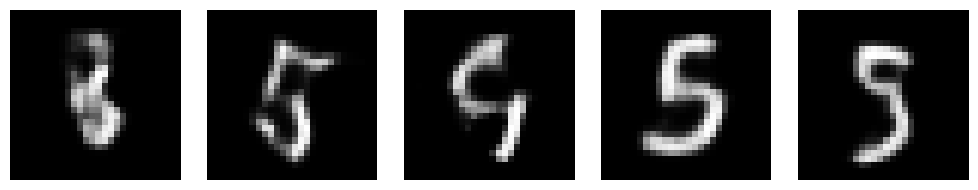

In [ ]:
generated = generated.cpu()

fig, axs = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    axs[i].imshow(generated[i].squeeze(), cmap='gray')
    axs[i].axis('off')
plt.tight_layout()
plt.show()
